In [1]:
import pandas as pd
import numpy as np
import pickle
pd.options.display.max_columns = None
import sys
sys.path.append("../")
import src.soporteCharts as charts
sys.path.append("../")
import src.soportecleaning as sc

# Region selection
Checking the data from the [given](https://www.kaggle.com/datasets/andrewmvd/spotify-playlists?select=spotify_dataset.csv) database.

In [2]:
data = pd.read_csv('../data/charts.csv', sep = ',', on_bad_lines='skip')
print(data.shape)
data.head()

(26173514, 9)


,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.000
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.000
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.000
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.000
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.000


In [3]:
data[['region', 'chart']].value_counts()

region         chart  
Brazil         top200     364516
Argentina      top200     364385
United States  top200     364184
Austria        top200     363925
Australia      top200     362189
                           ...  
India          viral50     51688
Ukraine        viral50     26778
Russia         viral50     26069
South Korea    viral50     16700
Luxembourg     top200       8962
Name: count, Length: 139, dtype: int64

For my analysis, I will consider one of the regions given by the dataset. In this case, USA.

In [4]:
data[data['region'] == 'United States'][['region', 'chart']].value_counts()

region         chart  
United States  top200     364184
               viral50     90873
Name: count, dtype: int64

In [5]:
data_usa = data[(data['region'] == 'United States')]

# EDA

In [6]:
charts.analisis_basico(data_usa)

_________________________________

1_Data Structure: (455057, 9)


,title,rank,date,artist,url,region,chart,trend,streams
8246,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.000
8247,Fake Love,2,2017-01-01,Drake,https://open.spotify.com/track/343YBumqHu19cGo...,United States,top200,SAME_POSITION,1180074.000


<class 'pandas.core.frame.DataFrame'>
Index: 455057 entries, 8246 to 26173414
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   title    455057 non-null  object 
 1   rank     455057 non-null  int64  
 2   date     455057 non-null  object 
 3   artist   455057 non-null  object 
 4   url      455057 non-null  object 
 5   region   455057 non-null  object 
 6   chart    455057 non-null  object 
 7   trend    455057 non-null  object 
 8   streams  364184 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 34.7+ MB


None

_________________________________

2_Duplicated columns:
0
_________________________________

3_Null values distribution:


,title,rank,date,artist,url,region,chart,trend,streams
nulos,0,0,0,0,0,0,0,0,90873
dtypes,object,int64,object,object,object,object,object,object,float64


_________________________________

4_Numerical variables distribution:


,rank,streams
count,455057.000,364184.000
mean,85.525,390275.483
std,60.066,278800.877
min,1.000,122488.000
25%,32.000,236157.000
50%,76.000,294791.500
75%,138.000,434688.250
max,200.000,6146233.000


_________________________________

5_Categorical variables distribution:


,title,date,artist,url,region,chart,trend
count,455057,455057,455057,455057,455057,455057,455057
unique,11842,1826,5213,14650,1,2,4
top,goosebumps,2017-01-01,Juice WRLD,https://open.spotify.com/track/6gBFPUFcJLzWGx4...,United States,top200,MOVE_DOWN
freq,1778,250,10839,1778,455057,364184,195116


distribución de las variables numéricas en relación con la variable respuesta: streams


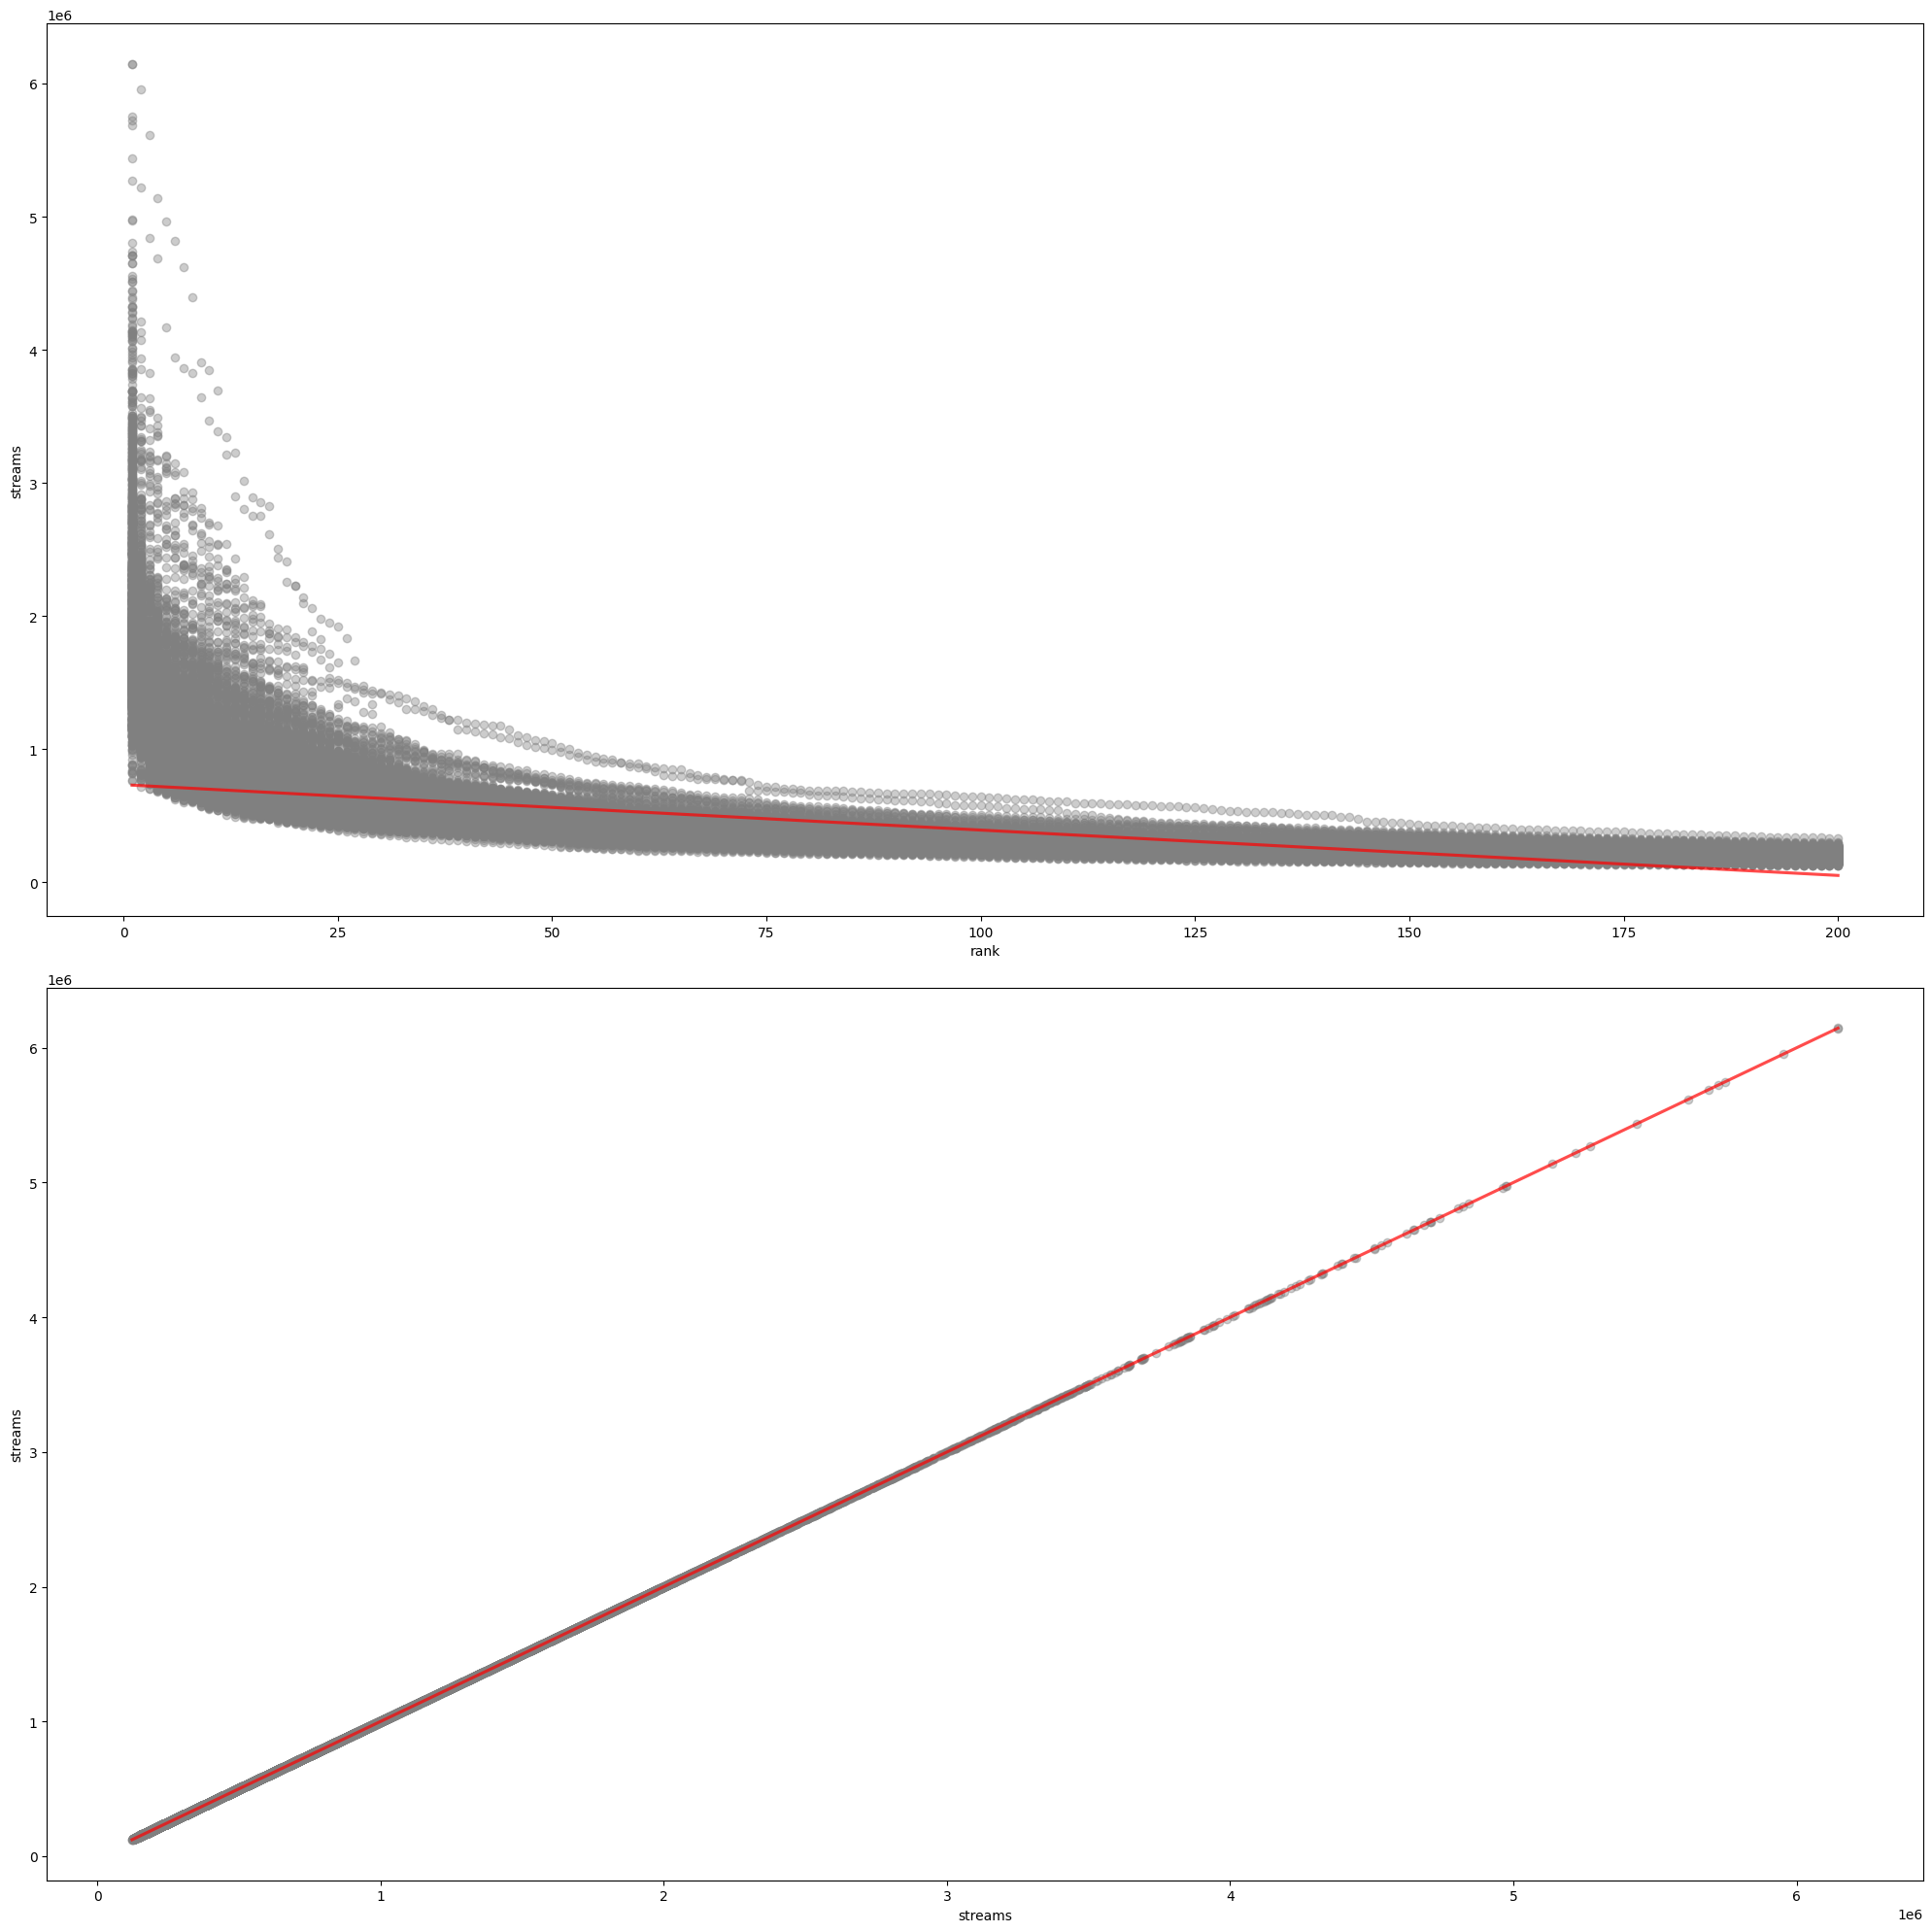

In [7]:
charts.regplot_numericas(data_usa, [], 'streams')

numeric variables distribution -> outliers


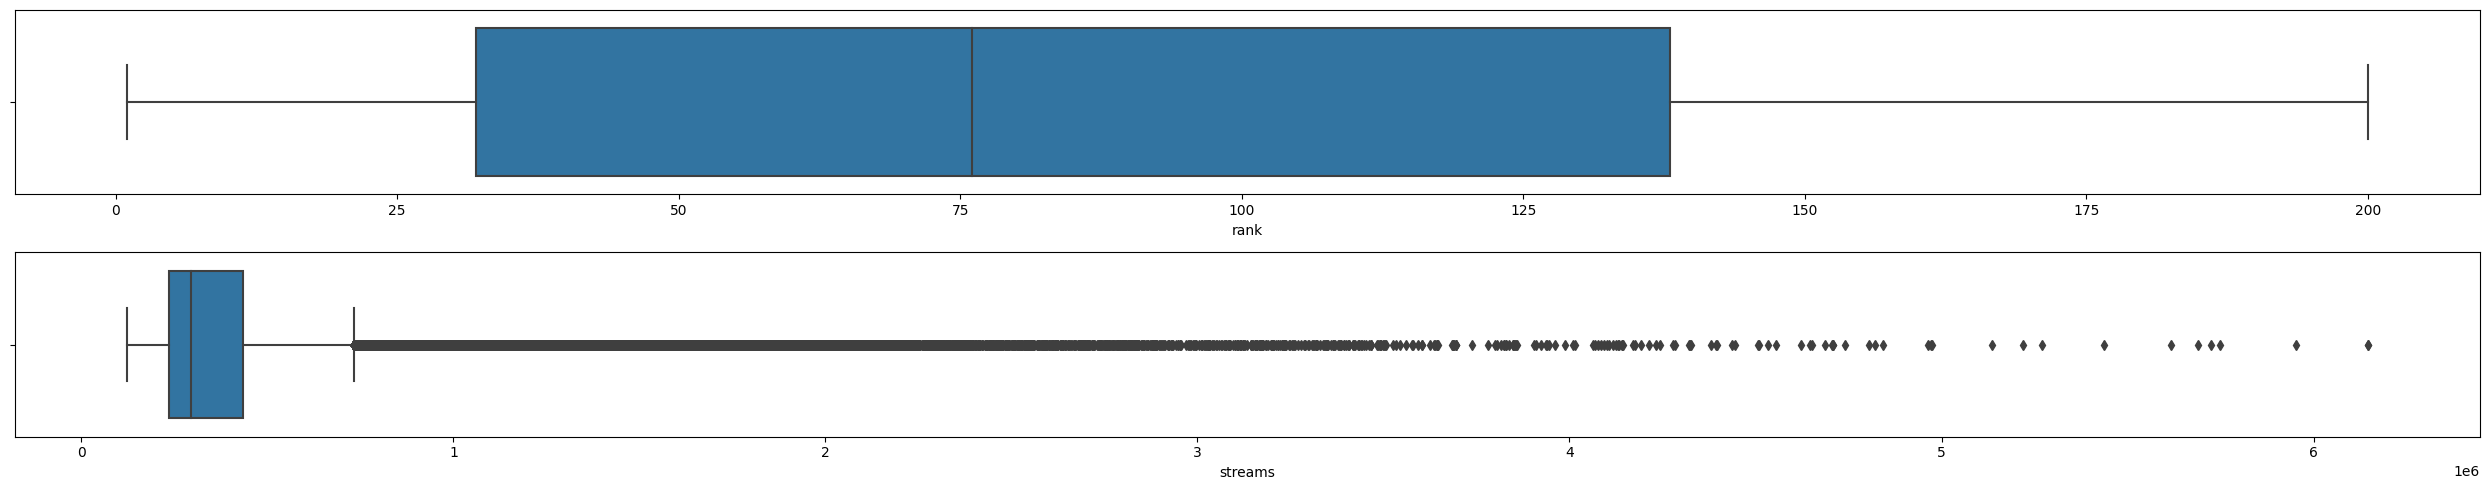

In [8]:
charts.chart_boxplot(data_usa)

numeric variables distribution


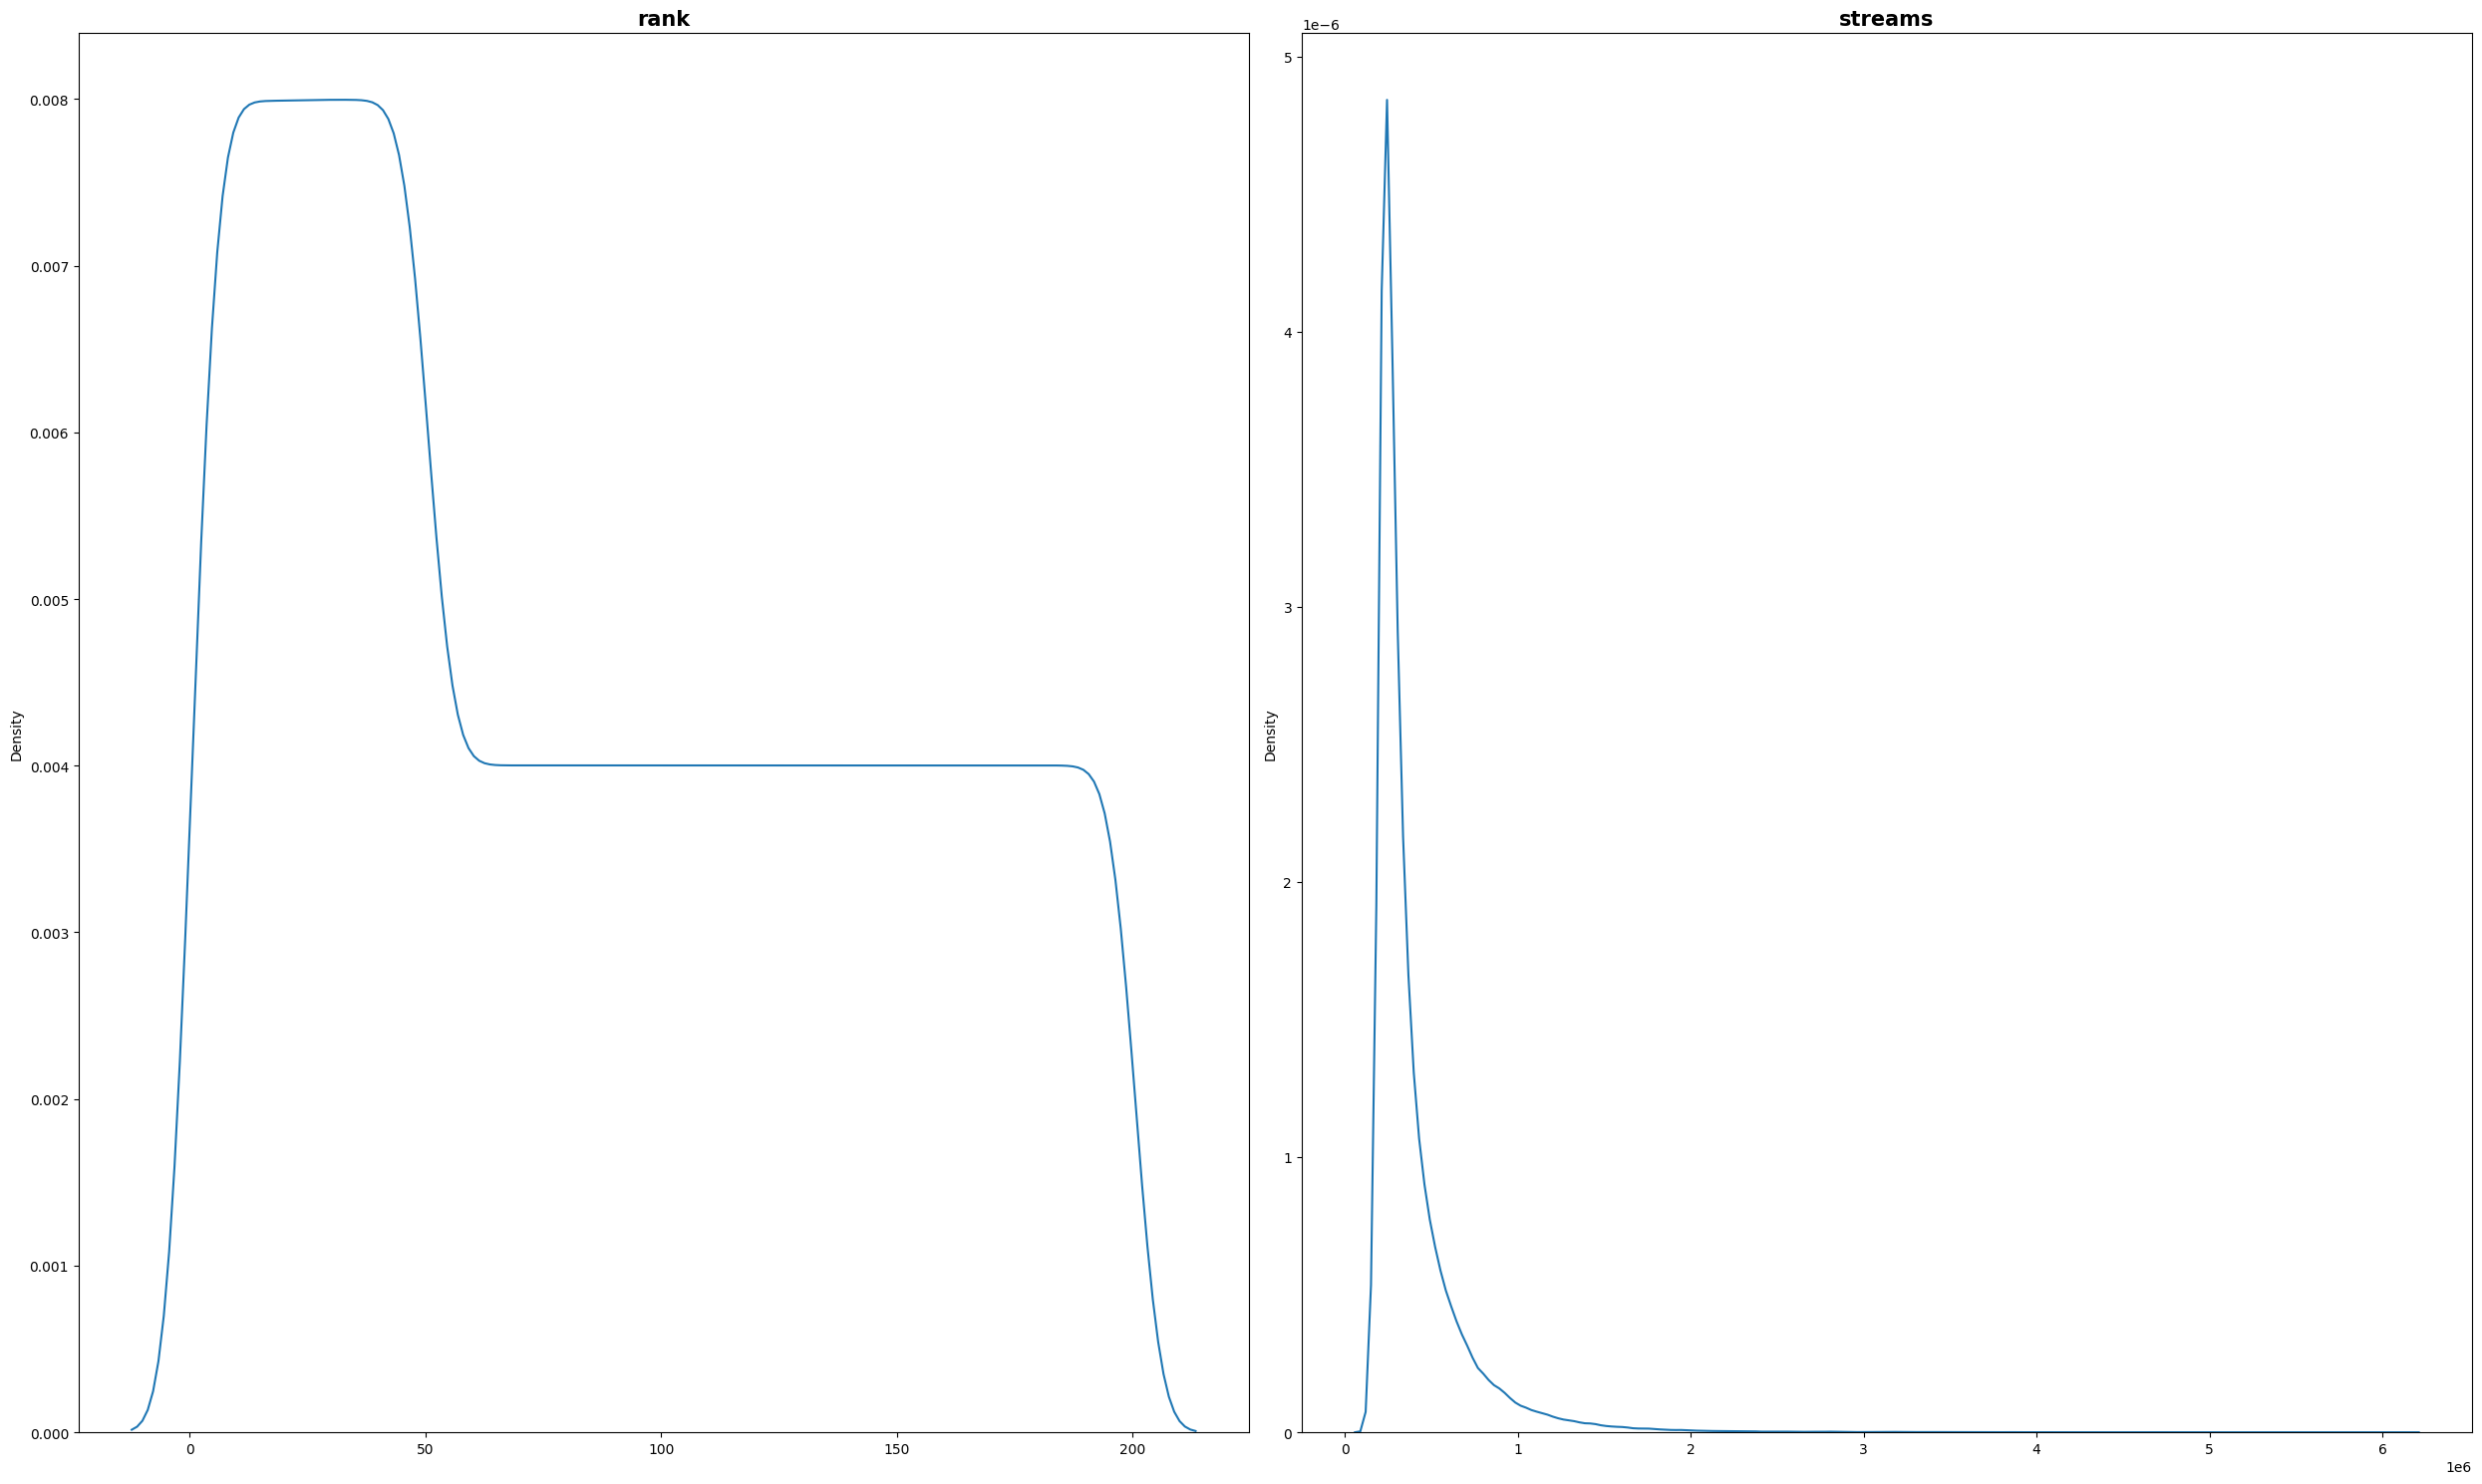

In [9]:
charts.distribucion_numericas(data_usa)

# Adding new columns

Adding columns for top ranking and weeks in charts

In [10]:
data_usa = sc.new_columns(data_usa)
print(data_usa.shape)
data_usa.head()

,title,rank,date,artist,url,region,chart,trend,streams,count,times_in_charts
0,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.000,429,1
1,Fake Love,2,2017-01-01,Drake,https://open.spotify.com/track/343YBumqHu19cGo...,United States,top200,SAME_POSITION,1180074.000,455,2
2,Starboy,3,2017-01-01,"The Weeknd, Daft Punk",https://open.spotify.com/track/5aAx2yezTd8zXrk...,United States,top200,SAME_POSITION,1064351.000,451,3
3,Closer,4,2017-01-01,"The Chainsmokers, Halsey",https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,United States,top200,SAME_POSITION,1010492.000,538,4
4,Black Beatles,5,2017-01-01,"Rae Sremmurd, Gucci Mane",https://open.spotify.com/track/6fujklziTHa8uoM...,United States,top200,SAME_POSITION,874289.000,240,5
...,...,...,...,...,...,...,...,...,...,...,...
455052,Bad Habits,46,2021-07-31,Ed Sheeran,https://open.spotify.com/track/6PQ88X9TkUIAUIZ...,United States,viral50,SAME_POSITION,NaN,14,21
455053,Not Around,47,2021-07-31,Nova,https://open.spotify.com/track/1Adhz5VVDZxhojO...,United States,viral50,SAME_POSITION,NaN,55,11
455054,Buy Dirt,48,2021-07-31,"Jordan Davis, Luke Bryan",https://open.spotify.com/track/69AIpwGNLxr4qS1...,United States,viral50,MOVE_UP,NaN,47,26
455055,Mónaco,49,2021-07-31,"LAGOS, Danny Ocean",https://open.spotify.com/track/3HgvO4B5LLmdPOT...,United States,viral50,NEW_ENTRY,NaN,19,35


In [11]:
data_usa.dtypes

title       object
rank         int64
date        object
artist      object
url         object
region      object
chart       object
trend       object
streams    float64
dtype: object

# Export
I will export the whole dataset and generate a dataset with the tracks and artist without duplicated rows.

In [12]:
with open('../data/pickle/playlist.pickle', 'wb') as data:
    pickle.dump(data_usa, data)

# Generate clean artist - track data
I will now get a unique list from the track - artist relation, in order to make api calls.

In [13]:
playlist = sc.playlist_output(data_usa)
print(playlist.shape)
playlist.head()

selecting columns: (455057, 3)
total artists: 455057 ; total songs (with unique names): 455057 ; unique artists: 5213 ; unique songs (with unique names): 11842
dropping duplicates (14663, 3)
unique artists: 5213 ; unique songs (with unique names): 11842
artist clean column 14663 original artist column 5213
tracks clean column 11635 tracks original column 11842
(14663, 5)


,title,artist,url,artist_clean,track_clean
8246,Bad and Boujee (feat. Lil Uzi Vert),Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,migos,bad and boujee (feat. lil uzi vert)
8247,Fake Love,Drake,https://open.spotify.com/track/343YBumqHu19cGo...,drake,fake love
8248,Starboy,"The Weeknd, Daft Punk",https://open.spotify.com/track/5aAx2yezTd8zXrk...,"the weeknd, daft punk",starboy
8249,Closer,"The Chainsmokers, Halsey",https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,"the chainsmokers, halsey",closer
8250,Black Beatles,"Rae Sremmurd, Gucci Mane",https://open.spotify.com/track/6fujklziTHa8uoM...,"rae sremmurd, gucci mane",black beatles


# Conversion
I will save the input file as .pkl as the original one is too big for github.

In [ ]:
with open('../data/pickle/artist.pickle', 'wb') as data_nowplaying:
    pickle.dump(playlist[['url', 'artist_clean', 'track_clean']], data_nowplaying)